[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/combine-org/combine-notebooks/main?labpath=notebooks%2Fsbgn.ipynb)
<a href="https://colab.research.google.com/github/combine-org/combine-notebooks/blob/main/notebooks/sbgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab\"/></a>

# Simple SBGN example

This notebook creates simple models in [SBGN](https://www.nature.com/articles/nrg3885). The same [biological system](doi:10.1038/nrg3885) is shown in different languages of SBGN: Activity Flow (AF), Process Description (PD) and Entity Relationship (ER). Note the same set of four proteins in all cases. An activity flow diagram is used to show the stimulation of c-FOS activity by ELK1 activity, the stimulation of ELK1 activity by ERK activity, and its inhibition by UBC9 activity. 

<center>
<img src="./results/hello_world_sbgn_af.png" alt="SBGN Example 1">
</center>

A process description diagram is then used to show the catalysis of ELK1 sumoylation (SUMO) and phosphorylation (P), their reversed reactions, and the trigger of c-FOS expression.

<center>
<img src="./results/hello_world_sbgn_pd.png" alt="SBGN Example 2">
</center>

In the last section, an entity relationships is used to describe the stimulation of sumoylation and phosphorylation of ELK1 by UBC9 and ERK, respectively, and the influence of these processes on c-FOS.

<center>
<img src="./results/hello_world_sbgn_er.png" alt="SBGN Example 3">
</center>

## 1) Including libraries and helper functions

Note: the cell below runs some code to determine where the notebook is running (e.g. on your local machine or on Binder), and decides where to save results. If it is hidden, click on the dots (•••) to view.

In [1]:
#note: metadata hides this cell on binder but it doesn't get hidden on colab
from pathlib import Path

#determine if we're running on colab
try:
  import google.colab
  exec_env = "colab"      #we seem to be on colab
  print("Assuming this notebook is running on Google Colab")
except:
  exec_env = "binder"     #assume it's binder

if exec_env == "colab":
  working_dir = f"{Path.cwd()}/combine-notebooks/notebooks/results"
  !git clone https://github.com/combine-org/combine-notebooks
  %cd combine-notebooks
  !pip install .
  %mkdir -p {working_dir}

else:
  #binder starts off in the notebook's folder
  working_dir = f"{Path.cwd()}/results"

import os
os.chdir(working_dir)

print("Results will be saved in %s"%working_dir)

Results will be saved in /Users/padraig/git/combine-notebooks/notebooks/results


In [2]:
from pathlib import Path

from IPython.display import Image, display
import libsbgnpy.libsbgn as libsbgn
from libsbgnpy.libsbgnTypes import ArcClass, GlyphClass, Language
from libsbgnpy import render
import copy

RESULTS_DIR =  Path(working_dir) # determined based on the running environment above


SBGN diagrams are a specific set of graphs and thus make
use of concepts from graph theory. The following list defines
the terms used most often.
- __Arc:__ A directed edge, that is, an edge that is not symmetrical in shape.
- __Edge:__ A line joining two nodes.
- __Glyph:__ A symbol that conveys information nonverbally.
- __Graph:__ A set of nodes connected with edges.
- __Node:__ A point that terminates a line or curve or comprises the intersection of two or more lines or curves.

Below we have helper functions that will create glyphs and arcs in the libsbgn library.

In [3]:
def create_glyph(glyph_class, box_values, id, text = None, child_glyphs = [], ports = []):
    """Creates and returns a glyph object.  A glyph is a symbol that conveys information nonverbally."""
    
    # Create glyph object and set the type of glyph
    g = libsbgn.glyph(class_=glyph_class, id=id)
    
    # Set size and location of the glyph
    g.set_bbox(libsbgn.bbox(y=box_values[0], x=box_values[1], h=box_values[2], w=box_values[3]))
    
    # If text is given, add a label with that text
    if text is not None:
        g.set_label(libsbgn.label(text=text))

    # Add any child glyphs to the main glyph
    for c in child_glyphs:
        g.add_glyph(c)

    # Add any port to the glyph
    for p in ports:
        g.add_port(p)

    return g

In [4]:
def create_arc(arc_class, id, start, end, source, target):
    """Create and return an arc object. An arc is a directed edge, that is, an edge that is not symmetrical in shape."""
    
    # Create the arc object
    a = libsbgn.arc(class_=arc_class, target=target, source=source, id=id)
    
    # Set the start and end points of the arc
    a.set_start(libsbgn.startType(y=start[0], x=start[1]))
    a.set_end(libsbgn.endType(y=end[0], x=end[1]))
    
    return a

In [5]:
def render_image(sbgn):
    """Display an SBGN diagram"""

    # Create a temporary file for image
    RESULTS_DIR.mkdir(parents=True, exist_ok=True)
    f_png = RESULTS_DIR / 'temp_sbgn.png'
    
    # Display the image
    render.render_sbgn(sbgn, image_file=str(f_png), file_format="png")
    display(Image(f_png, width=400))

    # Delete temporary file
    f_png.unlink()

## 2) Activity Flow Example

The [SBGN Activity Flow (AF) language](https://github.com/combine-org/combine-specifications/blob/main/specifications/sbgn.af.level-1.version-1.2.md) depicts the flow of information between biochemical entities in a network. It omits information about the state transitions of entities and is particularly convenient for representing the effects of perturbations, whether genetic or environmental in nature.

The first step in creating an Activity Flow diagram is to create an `sbgn` object and set the language to `Language.AF`.

In [6]:
# Create SBGN object
sbgn: libsbgn.sbgn = libsbgn.sbgn()

# Set the language to Activity Flow
map = libsbgn.map()
map.set_language(Language.AF)
sbgn.set_map(map)

Create four biological activity glyphs, each one corresponding to a protein: ubc9, elk-1, erk, and c-fos.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


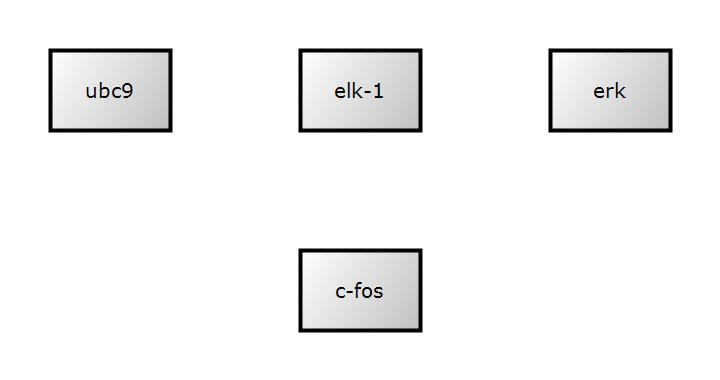

In [7]:
g = create_glyph(GlyphClass.BIOLOGICAL_ACTIVITY, [25.0, 25.0, 40.0, 60.0], 'glyph0', 'ubc9')
map.add_glyph(g)

g = create_glyph(GlyphClass.BIOLOGICAL_ACTIVITY, [25.0, 150.0, 40.0, 60.0], 'glyph1', 'elk-1')
map.add_glyph(g)

g = create_glyph(GlyphClass.BIOLOGICAL_ACTIVITY, [25.0, 275.0, 40.0, 60.0], 'glyph2', 'erk')
map.add_glyph(g)

g = create_glyph(GlyphClass.BIOLOGICAL_ACTIVITY, [125.0, 150.0, 40.0, 60.0], 'glyph3', 'c-fos')
map.add_glyph(g)

render_image(sbgn)

Create three arcs connecting the biological activity glyphs. Both negative and positive influcences of biological activities on each other is described by these arcs. The biochemical basis of a positive or negative influence in a given system is left undefined. For this reason, this type of SBGN diagram should not exist alone; it should be associated, when possible, with detailed entity relationship and process diagram

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


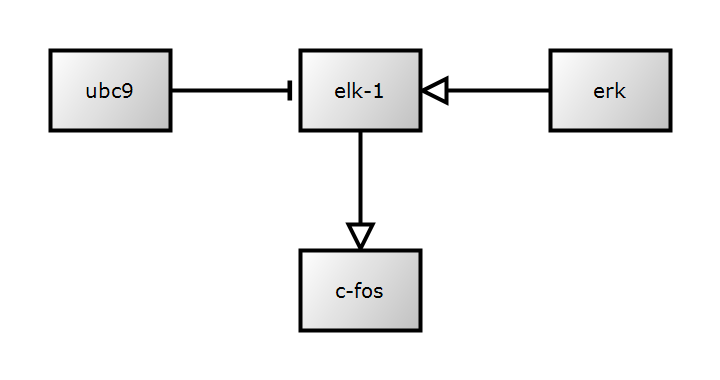

In [8]:
a = create_arc(ArcClass.POSITIVE_INFLUENCE, "arc0", [45.0, 275.0], [45.0, 211.0], "glyph2", "glyph1",)
map.add_arc(a)

a = create_arc(ArcClass.POSITIVE_INFLUENCE, "arc1", [65.0, 180.0], [124.0, 180.0], "glyph1", "glyph3")
map.add_arc(a)

a = create_arc(ArcClass.NEGATIVE_INFLUENCE, "arc2", [45.0, 85.0], [45.0, 145.0], "glyph0", "glyph1")
map.add_arc(a)

render_image(sbgn)

Save and print out the xml describing this SBGN diagram.

In [9]:
# Define the path to the sbgn file
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
sbgn_path = RESULTS_DIR / "hello_world_sbgn_af.sbgn"

# Save the pure SBGN xml
sbgn.write_file(sbgn_path)
xml = open(sbgn_path).read()

# Print out the xml describing the SBGN diagram
print(xml)

<?xml version="1.0" encoding="UTF-8"?>
<sbgn xmlns="http://sbgn.org/libsbgn/0.2">
    <map language="activity flow">
        <glyph class="biological activity" id="glyph0">
            <label text="ubc9"/>
            <bbox w="60." h="40." x="25." y="25."/>
        </glyph>
        <glyph class="biological activity" id="glyph1">
            <label text="elk-1"/>
            <bbox w="60." h="40." x="150." y="25."/>
        </glyph>
        <glyph class="biological activity" id="glyph2">
            <label text="erk"/>
            <bbox w="60." h="40." x="275." y="25."/>
        </glyph>
        <glyph class="biological activity" id="glyph3">
            <label text="c-fos"/>
            <bbox w="60." h="40." x="150." y="125."/>
        </glyph>
        <arc class="positive influence" id="arc0" source="glyph2" target="glyph1">
            <start x="275." y="45."/>
            <end x="211." y="45."/>
        </arc>
        <arc class="positive influence" id="arc1" source="glyph1" target="

Save the SBGN diagram as png image file.

In [10]:
f_png = RESULTS_DIR / 'hello_world_sbgn_af.png'
render.render_sbgn(sbgn, image_file=str(f_png), file_format="png")

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/hello_world_sbgn_af.png


## 3) Process Description Example

The [SBGN Process Description (PD) language](https://sbgn.github.io/downloads/specifications/pd_level1_version2.pdf) shows the temporal courses of biochemical interactions in a network. It can be used to show all the molecular interactions taking place in a network of biochemical entities, with the same entity appearing multiple times in the same diagram.

The first step in creating an Process Description diagram is to create an `sbgn` object and set the language to `Language.PD`.

In [11]:
# Create an SBGN object
sbgn: libsbgn.sbgn = libsbgn.sbgn()

# Set the language to Process Description
map = libsbgn.map()
map.set_language(Language.PD)
sbgn.set_map(map)

Next, we will create a `MACROMOLECULE` glyph for elk-1 in three seperate forms.  Note that each instance of elk-1 has two child `STATE_VARIABLE` gylphs which help describe the form at some point during the process.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


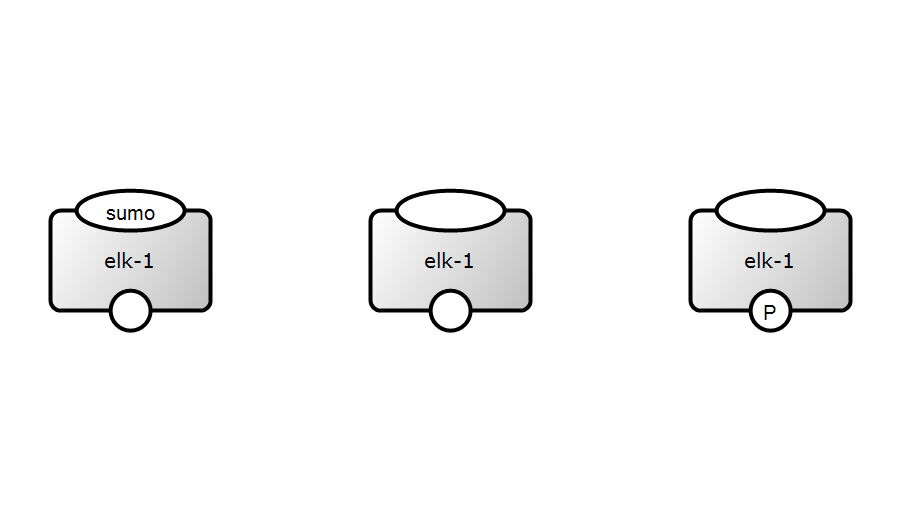

In [12]:
upper_g = create_glyph(GlyphClass.STATE_VARIABLE, [145.0, 55.0, 20.0, 20.0], 'glyph4.1')
lower_g = create_glyph(GlyphClass.STATE_VARIABLE, [95.0, 38.0, 20.0, 54.0], 'glyph4.2', 'sumo')
g = create_glyph(GlyphClass.MACROMOLECULE, [105.0, 25.0, 50.0, 80.0], 'glyph4', 'elk-1', [upper_g, lower_g])
map.add_glyph(g)

upper_g = create_glyph(GlyphClass.STATE_VARIABLE, [145.0, 215.0, 20.0, 20.0], 'glyph1.1')
lower_g = create_glyph(GlyphClass.STATE_VARIABLE, [95.0, 198.0, 20.0, 54.0], 'glyph1.2')
g = create_glyph(GlyphClass.MACROMOLECULE, [105.0, 185.0, 50.0, 80.0], 'glyph1', 'elk-1', [upper_g, lower_g])
map.add_glyph(g)

upper_g = create_glyph(GlyphClass.STATE_VARIABLE, [145.0, 375.0, 20.0, 20.0], 'glyph9.1', 'P')
lower_g = create_glyph(GlyphClass.STATE_VARIABLE, [95.0, 358.0, 20.0, 54.0], 'glyph9.2')
g = create_glyph(GlyphClass.MACROMOLECULE, [105.0, 345.0, 50.0, 80.0], 'glyph9', 'elk-1', [upper_g, lower_g])
map.add_glyph(g)

render_image(sbgn)

We now add another set of glyphs describing the ends of the process and the resulting c-fos protein.  Here we also introduce the `PROCESS` glyph which contains several ports. These ports will be used to connect glyphs via arcs.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


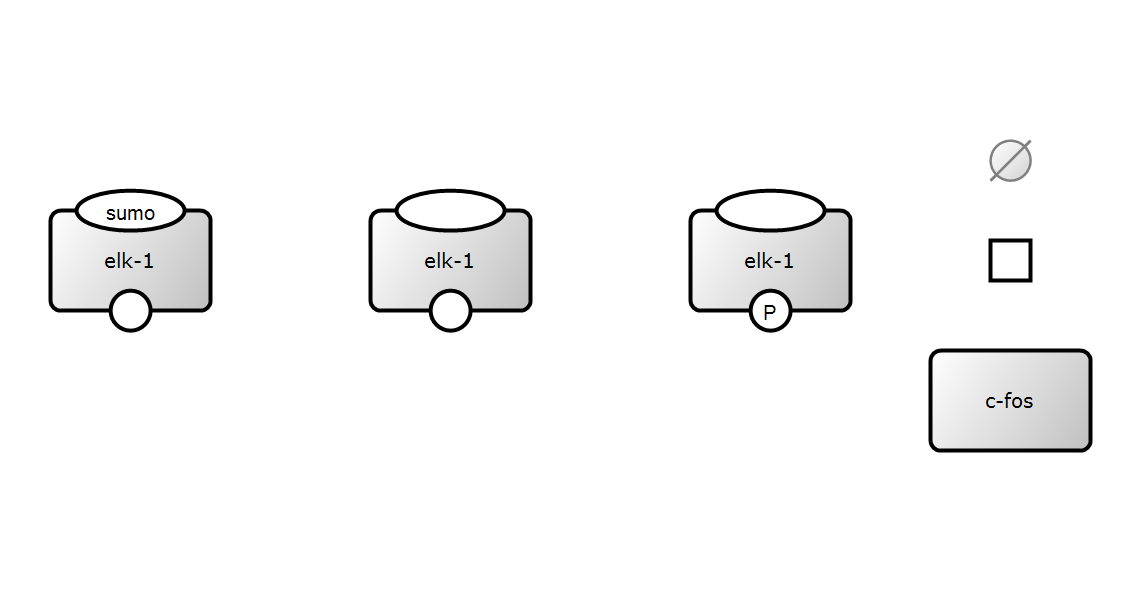

In [13]:
g = create_glyph(GlyphClass.MACROMOLECULE, [175.0, 465.0, 50.0, 80.0], 'glyph10', 'c-fos')
map.add_glyph(g)

ports = [
    libsbgn.port(y=120.0, x=505.0, id='glyph11.1'), 
    libsbgn.port(y=130.0, x=495.0, id='glyph11.2'), 
    libsbgn.port(y=140.0, x=505.0, id='glyph11.3')
]
g = create_glyph(GlyphClass.PROCESS, [120.0, 495.0, 20.0, 20.0], 'glyph11', None, [], ports)
map.add_glyph(g)

g = create_glyph(GlyphClass.SOURCE_AND_SINK, [70.0, 495.0, 20.0, 20.0], 'glyph12')
map.add_glyph(g)

render_image(sbgn)

Add more `PROCESS` glyphs that will manage the change between the different version of elk-1.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


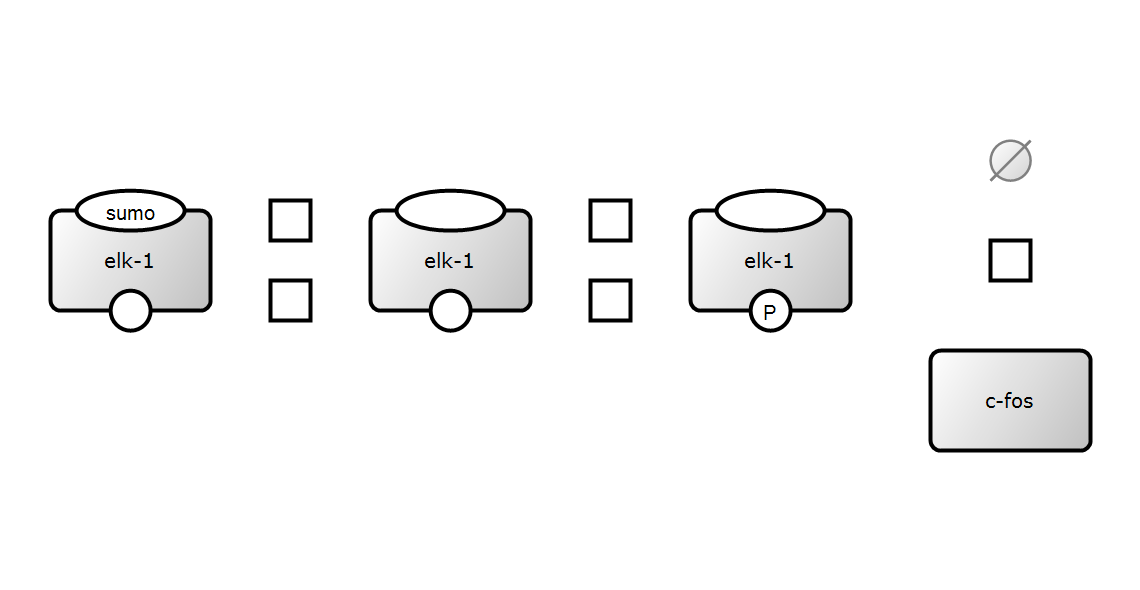

In [14]:
ports = [libsbgn.port(y="150.0", x="155.0", id="glyph3.1"), libsbgn.port(y="150.0", x="135.0", id="glyph3.2")]
g = create_glyph(GlyphClass.PROCESS, [140.0, 135.0, 20.0, 20.0], 'glyph3', None, [], ports)
map.add_glyph(g)

ports = [libsbgn.port(y="110.0", x="155.0", id="glyph5.1"), libsbgn.port(y="110.0", x="135.0", id="glyph5.2")]
g = create_glyph(GlyphClass.PROCESS, [100.0, 135.0, 20.0, 20.0], 'glyph5', None, [], ports)
map.add_glyph(g)

ports = [libsbgn.port(y="150.0", x="315.0", id="glyph7.1"), libsbgn.port(y="150.0", x="295.0", id="glyph7.39")]

g = create_glyph(GlyphClass.PROCESS, [140.0, 295.0, 20.0, 20.0], 'glyph7', None, [], ports)
map.add_glyph(g)

ports = [libsbgn.port(y="110.0", x="315.0", id="glyph8.1"), libsbgn.port(y="110.0", x="295.0", id="glyph8.2")]
g = create_glyph(GlyphClass.PROCESS, [100.0, 295.0, 20.0, 20.0], 'glyph8', None, [], ports)
map.add_glyph(g)

render_image(sbgn)

Add `MACROMOLECULE` glyphs for ubc9 and erk.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


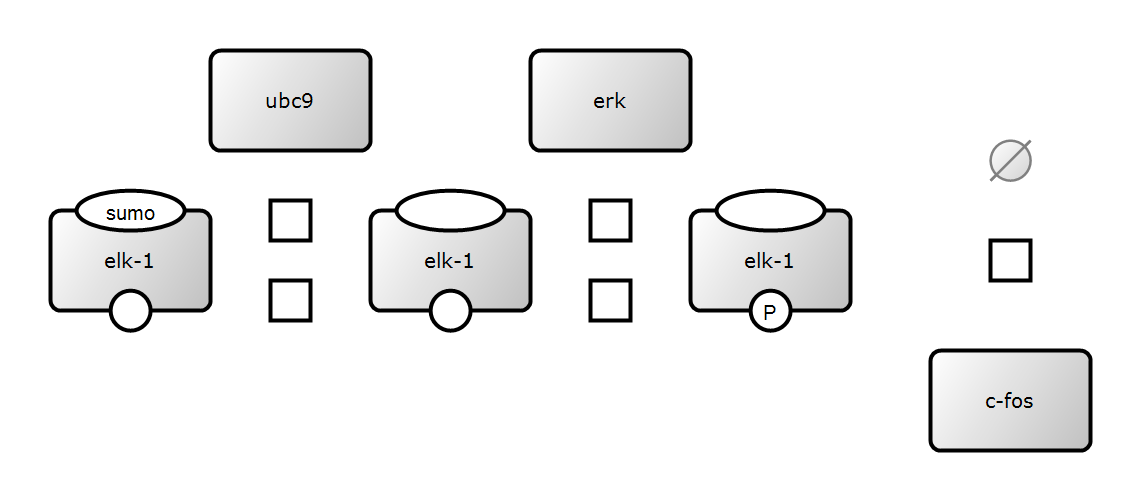

In [15]:
g = create_glyph(GlyphClass.MACROMOLECULE, [25.0, 105.0, 50.0, 80.0], 'glyph2', 'ubc9', [])
map.add_glyph(g)

g = create_glyph(GlyphClass.MACROMOLECULE, [25.0, 265.0, 50.0, 80.0], 'glyph6', 'erk', [])
map.add_glyph(g)

render_image(sbgn)

Adding two arcs between the ubc9 and erk macromolecules and process glyphs.  These arcs describe catalysis, the acceleration of a chemical reaction by a substance that is not consumed itself.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


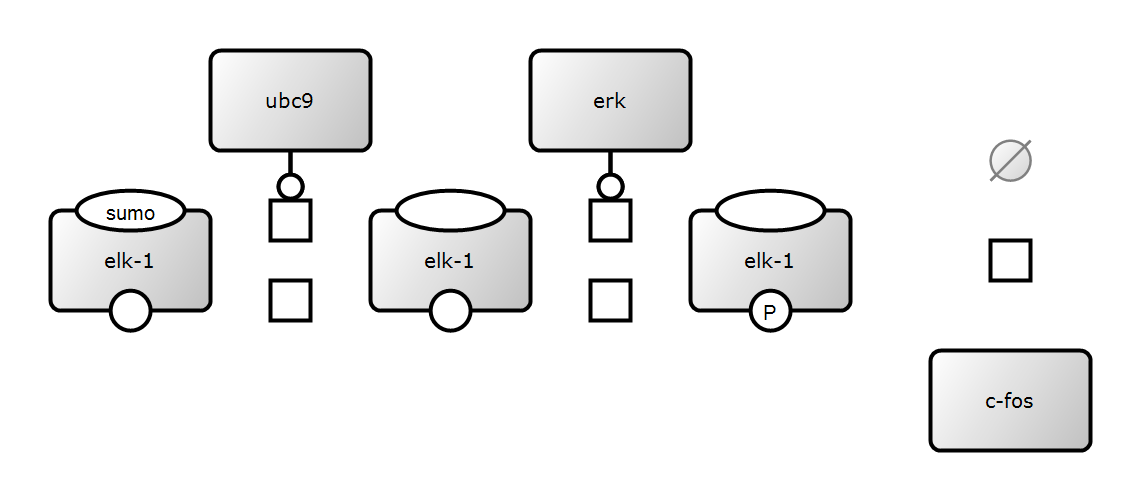

In [16]:
a = create_arc(ArcClass.CATALYSIS, 'arc1', [75.0, 145.0], [99.0, 145.0], 'glyph2', 'glyph5')
map.add_arc(a)

a = create_arc(ArcClass.CATALYSIS, 'arc5', [75.0, 305.0], [99.0, 305.0], 'glyph6', 'glyph8')
map.add_arc(a)

render_image(sbgn)

Add arcs showing the transition between different forms off elk-1.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


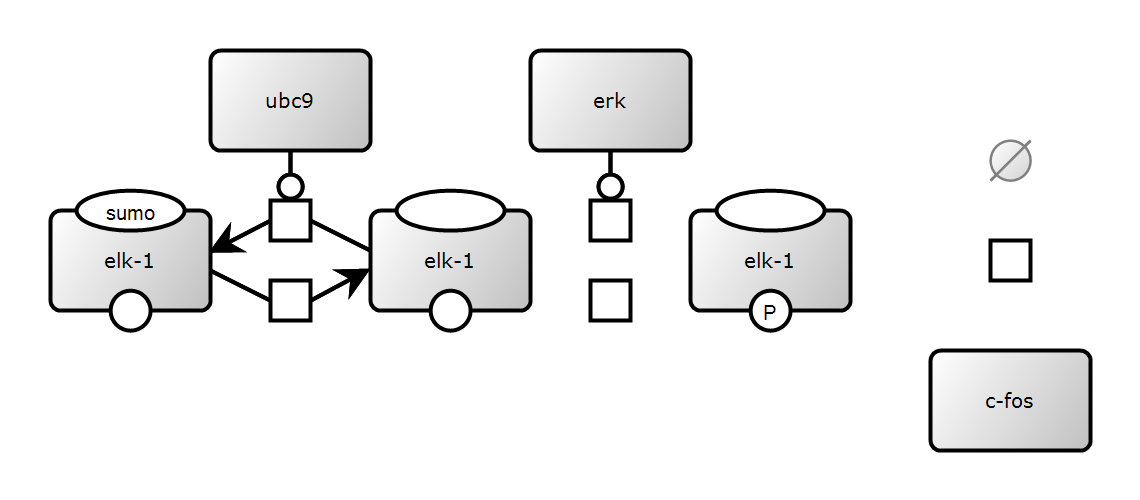

In [17]:
a = create_arc(ArcClass.PRODUCTION, 'arc2', [150.0, 155.0], [135.0, 183.0], 'glyph3.1', 'glyph1',)
map.add_arc(a)

a = create_arc(ArcClass.CONSUMPTION, 'arc0', [135.0, 105.0], [150.0, 135.0], 'glyph4', 'glyph3.2')
map.add_arc(a)

a = create_arc(ArcClass.PRODUCTION, 'arc3', [110.0, 135.0], [125.0, 106.0], 'glyph5.2', 'glyph4')
map.add_arc(a)

a = create_arc(ArcClass.CONSUMPTION, 'arc4', [125.0, 185.0], [110.0, 155.0], 'glyph1', 'glyph5.1')
map.add_arc(a)

render_image(sbgn)

Add more arcs showing the transition between different forms off elk-1.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


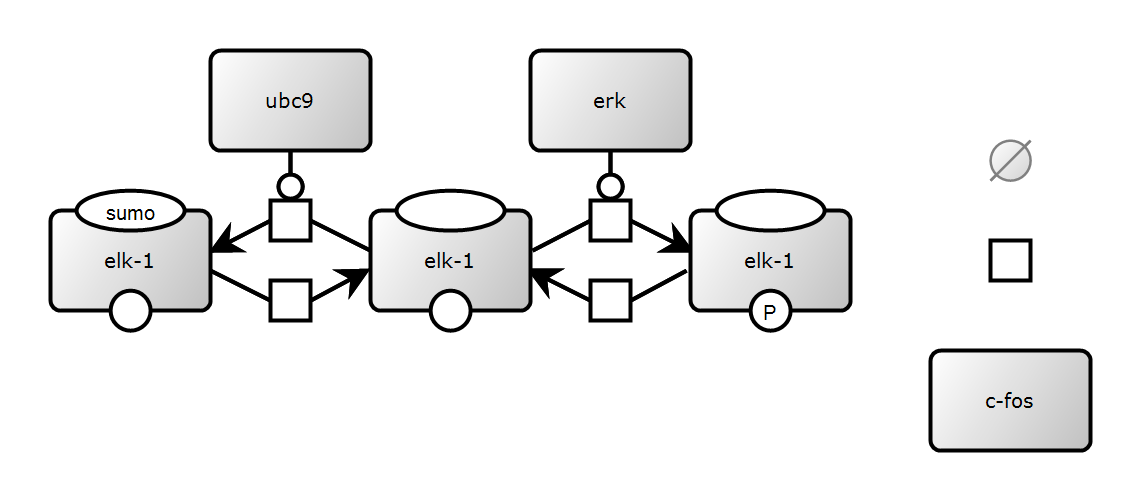

In [18]:
a = create_arc(ArcClass.CONSUMPTION, 'arc7', [135.0, 343.0], [150.0, 315.0], 'glyph9', 'glyph7.1')
map.add_arc(a)

a = create_arc(ArcClass.PRODUCTION, 'arc6', [150.0, 295.0], [135.0, 265.0], 'glyph7.39', 'glyph1')
map.add_arc(a)

a = create_arc(ArcClass.CONSUMPTION, 'arc8', [125.0, 266.0], [110.0, 295.0], 'glyph1', 'glyph8.2')
map.add_arc(a)

a = create_arc(ArcClass.PRODUCTION, 'arc9', [110.0, 315.0], [125.0, 345.0], 'glyph8.1', 'glyph9')
map.add_arc(a)

render_image(sbgn)

Add more arcs that show the process if elk-1 changing to c-fos.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


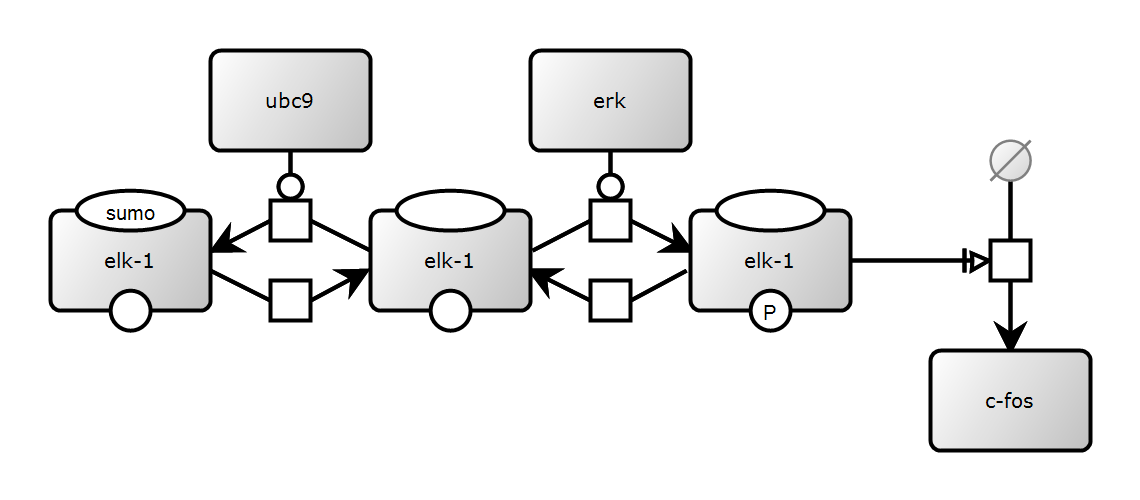

In [19]:
a = create_arc(ArcClass.PRODUCTION, 'arc13', [140.0, 505.0], [175.0, 505.0], 'glyph11.2', 'glyph10')
map.add_arc(a)

a = create_arc(ArcClass.NECESSARY_STIMULATION, 'arc11', [130.0, 395.0], [130.0, 494.0], 'glyph9', 'glyph11')
map.add_arc(a)

a = create_arc(ArcClass.CONSUMPTION, 'arc12', [90.0, 505.0], [120.0, 505.0], 'glyph12', 'glyph11.1')
map.add_arc(a)

render_image(sbgn)

Save and print out the xml describing this SBGN diagram.

In [20]:
# Define the path to the sbgn file
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
sbgn_path = RESULTS_DIR / "hello_world_sbgn_pd.sbgn"

# Save the pure SBGN xml
sbgn.write_file(sbgn_path)
xml = open(sbgn_path).read()

# Print out the xml describing the SBGN diagram
print(xml)

<?xml version="1.0" encoding="UTF-8"?>
<sbgn xmlns="http://sbgn.org/libsbgn/0.2">
    <map language="process description">
        <glyph class="macromolecule" id="glyph4">
            <label text="elk-1"/>
            <bbox w="80." h="50." x="25." y="105."/>
            <glyph class="state variable" id="glyph4.1">
                <bbox w="20." h="20." x="55." y="145."/>
            </glyph>
            <glyph class="state variable" id="glyph4.2">
                <label text="sumo"/>
                <bbox w="54." h="20." x="38." y="95."/>
            </glyph>
        </glyph>
        <glyph class="macromolecule" id="glyph1">
            <label text="elk-1"/>
            <bbox w="80." h="50." x="185." y="105."/>
            <glyph class="state variable" id="glyph1.1">
                <bbox w="20." h="20." x="215." y="145."/>
            </glyph>
            <glyph class="state variable" id="glyph1.2">
                <bbox w="54." h="20." x="198." y="95."/>
            </glyph>
        

Save the SBGN diagram as png image file.

In [21]:
f_png = RESULTS_DIR / 'hello_world_sbgn_pd.png'
render.render_sbgn(sbgn, image_file=str(f_png), file_format="png")

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/hello_world_sbgn_pd.png


## 4) Entity Relationship Example

The [SBGN Entity Relationship (ER) language](https://github.com/combine-org/combine-specifications/blob/main/specifications/sbgn.er.level-1.version-2.md) allows you to see all the relationships in which a given entity participates, regardless of the temporal aspects. Relationships can be seen as rules describing the influences of entities nodes on other relationships.

In this example, we will use entity relationships to describe the stimulation of sumoylation and phosphorylation of ELK1 by UBC9 and ERK, respectively, and the influence of these processes on c-FOS.

The first step in creating an Entity Relationship diagram is to create an `sbgn` object and set the language to `Language.ER`.

In [22]:
# Create a base SBGN object
sbgn: libsbgn.sbgn = libsbgn.sbgn()

# Set the language to Entity Relationship
map = libsbgn.map()
map.set_language(Language.ER)
sbgn.set_map(map)

Next, we will create our four `ENTITY` glyphs. Each entity corresponds to one of the following proteins: ubc9, erk, c-fos, and elk-1.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


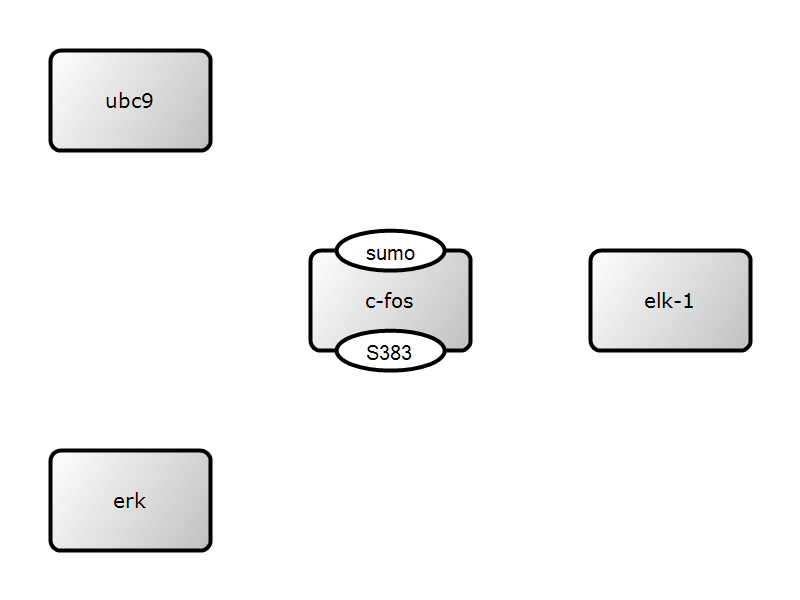

In [23]:
g = create_glyph(GlyphClass.ENTITY, [25.0, 25.0, 50.0, 80.0], 'glyph0', 'ubc9')
map.add_glyph(g)

g = create_glyph(GlyphClass.ENTITY, [225.0, 25.0, 50.0, 80.0], 'glyph1', 'erk')
map.add_glyph(g)

g = create_glyph(GlyphClass.ENTITY, [125.0, 155.0, 50.0, 80.0], 'glyph3', 'c-fos')
map.add_glyph(g)

upper_g = create_glyph(GlyphClass.STATE_VARIABLE, [165.0, 168.0, 20.0, 54.0], 'glyph2.1', 'S383')
lower_g = create_glyph(GlyphClass.STATE_VARIABLE, [115.0, 168.0, 20.0, 54.0], 'glyph2.2', 'sumo')
g = create_glyph(GlyphClass.ENTITY, [125.0, 295.0, 50.0, 80.0], 'glyph2', 'elk-1', [upper_g, lower_g])
map.add_glyph(g)

render_image(sbgn)

Add more glyphs that will be used to connect entities.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


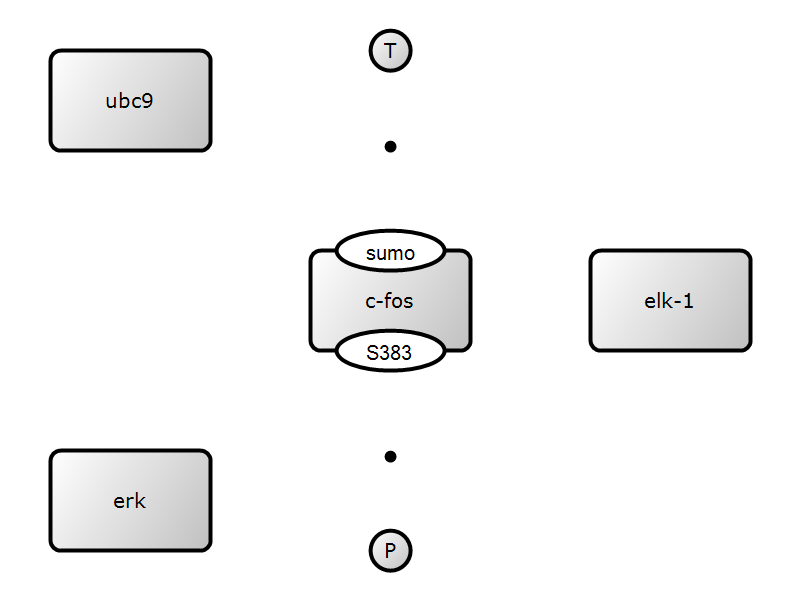

In [24]:
g = create_glyph(GlyphClass.VARIABLE_VALUE, [15.0, 185.0, 20.0, 20.0], 'glyph4', 'T')
map.add_glyph(g)

g = create_glyph(GlyphClass.VARIABLE_VALUE, [265.0, 185.0, 20.0, 20.0], 'glyph5', 'P')
map.add_glyph(g)

g = create_glyph(GlyphClass.OUTCOME, [70.0, 192.0, 6.0, 6.0], 'glyph6')
map.add_glyph(g)

g = create_glyph(GlyphClass.OUTCOME, [225.0, 192.0, 6.0, 6.0], 'glyph7')
map.add_glyph(g)

render_image(sbgn)

Next, we will connect some of our glyphs using assignment arcs.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


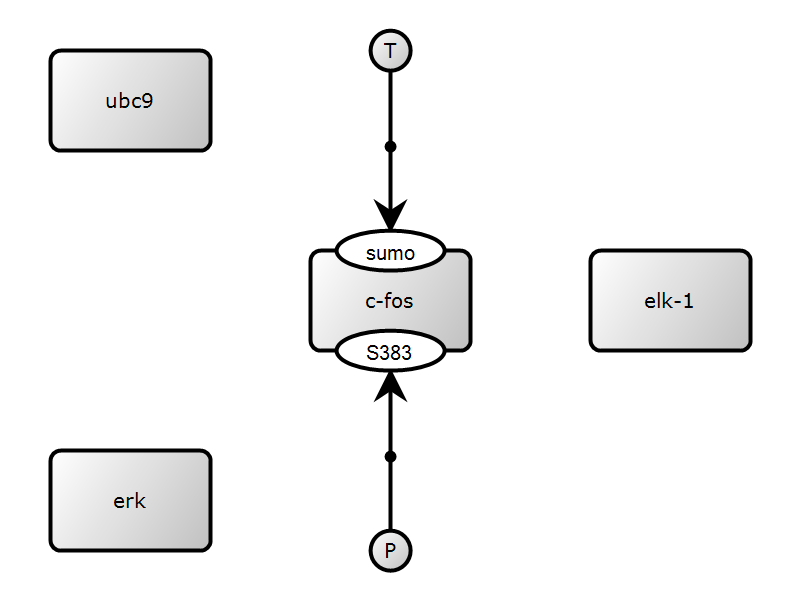

In [25]:
a = create_arc(ArcClass.ASSIGNMENT, 'arc0', [35.0, 195.0], [114.0, 195.0], 'glyph4', 'glyph2')
map.add_arc(a)

a = create_arc(ArcClass.ASSIGNMENT, 'arc1', [265.0, 195.0], [186.0, 195.0], 'glyph5', 'glyph2')
map.add_arc(a)

render_image(sbgn)

Now, we wil start adding stimulation arcs, these are a type of influnce.  Influences represent the effects of an entity on other relationships.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


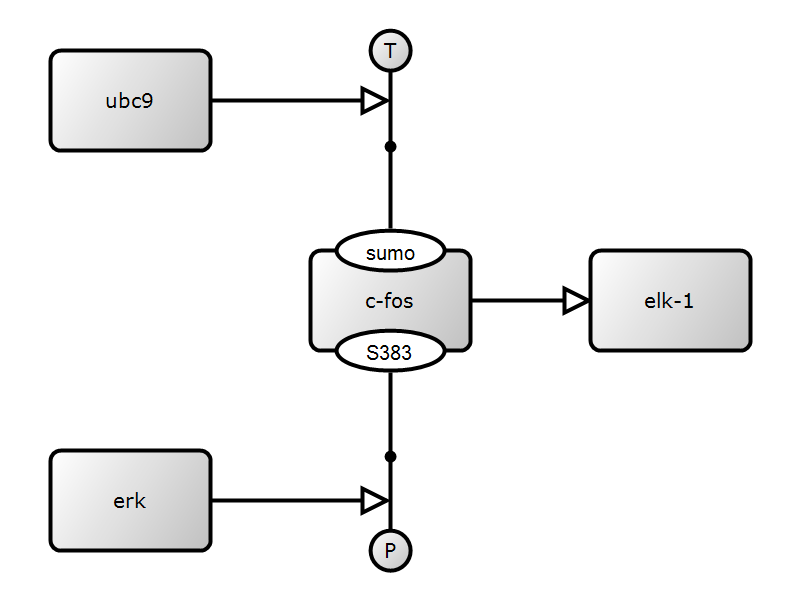

In [26]:
a = create_arc(ArcClass.STIMULATION, 'arc2', [50.0, 105.0], [50.0, 193.0], 'glyph0', 'arc0')
map.add_arc(a)

a = create_arc(ArcClass.STIMULATION, 'arc3', [250.0, 105.0], [250.0, 193.0], 'glyph1', 'arc1')
map.add_arc(a)

a = create_arc(ArcClass.STIMULATION, 'arc4', [150.0, 235.0], [150.0, 294.0], 'glyph2', 'glyph3')
map.add_arc(a)

render_image(sbgn)

Now we will add a final set of arcs, these are again all influcences.

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/temp_sbgn.png


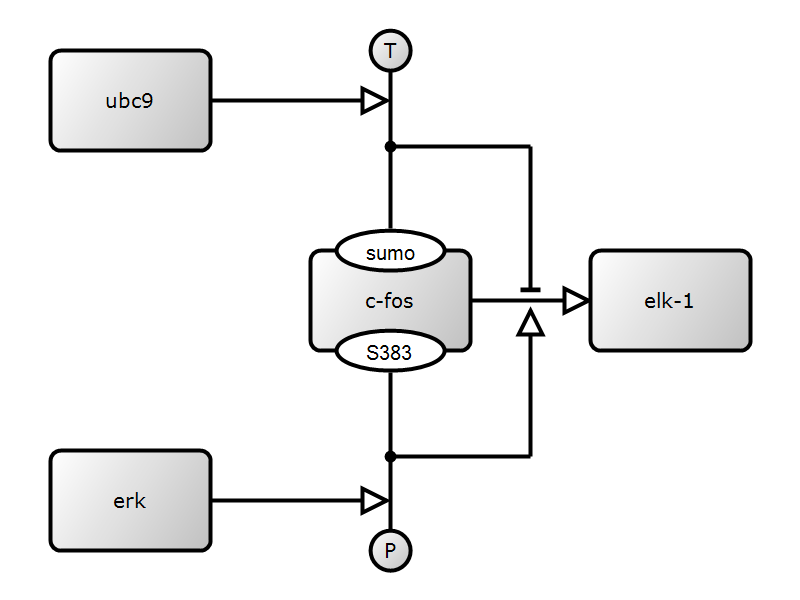

In [27]:
a = create_arc(ArcClass.STIMULATION, 'arc5', [228.0, 265.0], [155.0, 265.0], 'glyph7', 'arc4')
map.add_arc(a)

a = create_arc(ArcClass.LOGIC_ARC, 'arc6', [228.0, 195.0], [228.0, 265.0], 'glyph7', 'arc4')
map.add_arc(a)

a = create_arc(ArcClass.INHIBITION, 'arc7', [73.0, 265.0], [145.0, 265.0], 'glyph6', 'arc4')
map.add_arc(a)

a = create_arc(ArcClass.LOGIC_ARC, 'arc8', [73.0, 195.0], [73.0, 265.0], 'glyph6', 'arc4')
map.add_arc(a)

render_image(sbgn)

Save and print out the xml describing this SBGN diagram.

In [28]:
# Define the path to the sbgn file
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
sbgn_path = RESULTS_DIR / "hello_world_sbgn_er.sbgn"

# Save the pure SBGN xml
sbgn.write_file(sbgn_path)
xml = open(sbgn_path).read()

# Print out the xml describing the SBGN diagram
print(xml)

<?xml version="1.0" encoding="UTF-8"?>
<sbgn xmlns="http://sbgn.org/libsbgn/0.2">
    <map language="entity relationship">
        <glyph class="entity" id="glyph0">
            <label text="ubc9"/>
            <bbox w="80." h="50." x="25." y="25."/>
        </glyph>
        <glyph class="entity" id="glyph1">
            <label text="erk"/>
            <bbox w="80." h="50." x="25." y="225."/>
        </glyph>
        <glyph class="entity" id="glyph3">
            <label text="c-fos"/>
            <bbox w="80." h="50." x="155." y="125."/>
        </glyph>
        <glyph class="entity" id="glyph2">
            <label text="elk-1"/>
            <bbox w="80." h="50." x="295." y="125."/>
            <glyph class="state variable" id="glyph2.1">
                <label text="S383"/>
                <bbox w="54." h="20." x="168." y="165."/>
            </glyph>
            <glyph class="state variable" id="glyph2.2">
                <label text="sumo"/>
                <bbox w="54." h="20." x="

Save the SBGN diagram as png image file.

In [29]:
f_png = RESULTS_DIR / 'hello_world_sbgn_er.png'
render.render_sbgn(sbgn, image_file=str(f_png), file_format="png")

SBGN rendered: /Users/padraig/git/combine-notebooks/notebooks/results/hello_world_sbgn_er.png
